In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [6]:
def search_images(term, max_images = 30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results = max_images)).itemgot('image')

In [8]:
#Searching for correct images

urls = search_images("iphone", max_images = 1)
urls[0]

Searching for 'iphone'


'https://i5.walmartimages.com/asr/3a5ce2a3-3f38-414f-9724-5cead37da903.2a44fbcacd1b7e68a403a37ec0d0afda.jpeg'

### Downloading and inspecting image

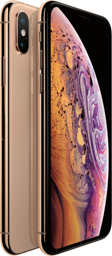

In [12]:
from fastdownload import download_url
dest = "iphone.jpg"
download_url(urls[0], dest, show_progress = False)


from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Repeating for samsung images 

Searching for 'samsung'


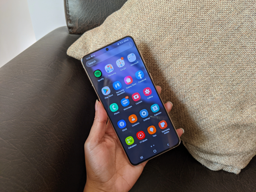

In [15]:
download_url(search_images("samsung", 1)[0], "samsung.jpg")
Image.open("samsung.jpg").to_thumb(256,256)


## Saving photos to folders

In [17]:
searches = "samsung", "iphone"
path = Path("samsung_or_iphone")
from time import sleep

for search_term in searches:
    dest = (path/search_term)
    dest.mkdir(exist_ok = True, parents = True)
    download_images(dest, urls = search_images(f"{search_term} photo"))
    sleep(10)
    download_images(dest, urls = search_images(f"{search_term} back photo"))
    sleep(10)
    download_images(dest, urls = search_images(f"{search_term} front photo"))
    resize_images(path/search_term, max_size = 400, dest= path/search_term)

Searching for 'samsung photo'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Searching for 'samsung back photo'
Searching for 'samsung front photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'iphone photo'
Searching for 'iphone back photo'
Searching for 'iphone front photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#### Removing failed photos 

In [19]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

## Training our model 

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #Inputs are images, outputs are categories
    get_items=get_image_files,#Returns a list of all image files in a path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #Train test splitting
    get_y=parent_label, #The y is the name of the parent folder they are in
    item_tfms=[Resize(192, method='squish')] #resizing images
).dataloaders(path, bs = 32)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.319395,1.094260,0.323529,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.721747,0.620403,0.264706,00:25
1,0.515477,0.326789,0.117647,00:27
2,0.372044,0.310410,0.147059,00:27


In [25]:
is_iphone,_, probs = learn.predict(PILImage.create('iphone.jpg'))
print(f"This is a: {is_iphone}.")
print(f"Probability it's a iphone: {probs[0]:.4f}")

This is a: samsung.
Probability it's a iphone: 0.3464


Didn't work very well, we can try other steps